In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as display
import time

from concurrent.futures import ThreadPoolExecutor
from preprocessing import load_image_from_path, image_to_numpy, random_augment_image, central_crop

%matplotlib inline

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
def get_files(root):
    PATHS = list()

    def parse_dir(root):
        if os.path.isfile(root):
            PATHS.append(root)
        elif os.path.isdir(root):
            for dirname in os.listdir(root):
                parse_dir(os.path.join(root, dirname))

    parse_dir(root)
    return PATHS

In [3]:
PATH_IMAGE = 'icons'

PATHS = get_files(PATH_IMAGE)

In [4]:
def get_labeled_image(path, size):

    def _get_label(path):
        label = tf.strings.split(path, sep=' ')[0]
        label = tf.strings.split(label, sep=os.sep)[-1]
        label = tf.strings.to_number(label, out_type=tf.int32) - 1
        return label

    label = _get_label(path)
    image = load_image_from_path(path.numpy(), target_size=size)

    return (image, label)

In [5]:
def get_data(paths, counts=100, target_size=None, split=False,):

    def get_augmented_image(path):
        image, label = get_labeled_image(path, target_size)
        image = random_augment_image(image)
        image = image_to_numpy(image) / 255.
        return [image, label]

    images = list()
    labels = list()
    data = list()

    paths = tf.random.shuffle(tf.repeat(paths, counts))
    size = len(paths)

    start_time = time.time()
    
    with ThreadPoolExecutor(32) as pool:
        data = list(pool.map(get_augmented_image, paths))

    for x, y in data:
        images.append(x)
        labels.append(y)

    tf.print("Loading data takes {:.3f}s".format(time.time()-start_time))

    if split:
        train_size = int(size*0.7)
        return (images[:train_size], labels[:train_size]), (images[train_size:], labels[train_size:])
    else:
        return images, labels

In [13]:
(train_images, train_labels), (test_images, test_labels) = get_data(PATHS, counts=10, target_size=(150, 150), split=True)

Loading data takes 8.497s


In [14]:
tf.shape(train_images)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 70, 150, 150,   3])>

In [31]:
class Outline(tf.keras.layers.Layer):
    def __init__(self, strides=1, padding='SAME', **kwargs):
        super().__init__(**kwargs)
        self.outline_filter = tf.constant([[
            [[1], [0], [-1]],
            [[2], [0], [-2]],
            [[1], [0], [-1]]
        ]], dtype=tf.float32)
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.conv2d(inputs, self.outline_filter, self.strides, self.padding)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((150, 150, 3)),
    tf.keras.layers.Reshape((1, 150, 150, 3)),
    Outline(),
    tf.keras.layers.Reshape((150, 150, 1)),
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1, 150, 150, 3)    0         
_________________________________________________________________
outline_4 (Outline)          (None, 1, 150, 150, 1)    0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 150, 150, 1)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [25]:
filtered = model(np.array(train_images))

In [28]:
def show_images(data, num_rows, num_cols):
    indexes = np.random.choice(len(data), num_rows*num_cols, replace=True)
    plt.figure(figsize=(num_rows*2, num_rows*2))
    for i, index in enumerate(indexes):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[index].numpy(), cmap="gray")
        plt.axis("off")
    plt.show()

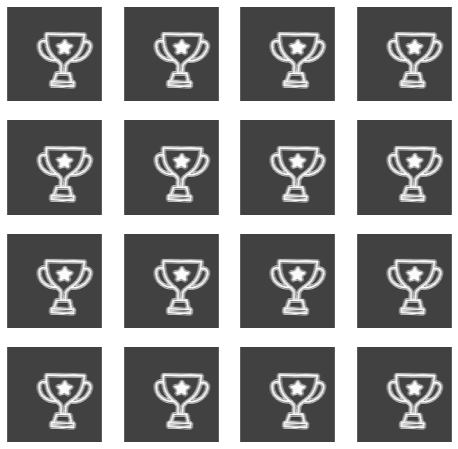

In [29]:
show_images(filtered, 4, 4)

In [30]:
filtered.shape

TensorShape([1, 150, 150, 1])